# Preprocessing and registration
This notebook does basic preprocessing and registration for lightsheet data

Note v2 uses my saved data that was downsampled from imaris

version 3a contains downsampled data from imaris with origin and pixel set with metadata. It also has a fix where sampling was done on padded coordinates rather than unpadded

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join as pathjoin
import time

import sys
sys.path.append('..')
import imp
import donglab_workflows as dw
imp.reload(dw)

import torch # this will just set the dtype


In [2]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [3]:
# Note
# STEP 1:
# we use the allen institute 50 micron atlas to compute a transformation
# this is a displacement vector as a function of space
# STEP 2:
# this can be used to deform images (include segmentation labels) between microscopy data and the atlas
# AND it can be used to deform point sets (like swc files) between microscopy data and atlas
# 

In [4]:
# NOTE
# the quality of the surfaces is not very good.
# 
# i) Input to registration pipeline is microscopy data downsampled to 50um resolution
# ii) After we compute the transformations, we apply them to yongsoo's labels.  These labels get resampled at 50 microns.
# iii) We convert these labels to surfaces.  Therefore the triangles on the surface have a resolution of about 50 microns.
#
# problem: triangles are too big, AND at 50 micron resolution some regions have very few pixels in them.
# we can fix both of those problems by changing STEP 2. 
# point ii), when we transform yongsoo's labels, we want to sample them at 20 microns (their native resolution)

In [5]:
# TODO
# in the future we'll use the 25 micron atlas, and 25 micron data
# daniel will run this and get parameters that work.

In [6]:
# TODO: collect all input arguments in this cell
target_name = '/nafs/dtward/dong/final_output/SW220510_LS/SW220510_02_LS_6x_1000z_ch_0_pow_[0.125]_down.npz'


# the target below, brain 1, is very inhomogeneous, stain did not penetrate far below the surface
target_name = '/qnap/Luis/results/20220605_SW220406_01_LS_6x_1000z/downsample_50/SW220406_01_LS_6x_1000z_flip_ud_ch_0_pow_[0.125]_down.npz'
# Luis showed me pictures of the above brain, the labels don't line up well, 
# Daniel thinks the issue is the registration is bad because of the low quality data and will fix it
# the target below "brain 2" has much better contrast.
target_name = '/qnap/Luis/results/SW220510_02_LS_6x_1000z/downsample_20/SW220510_02_LS_6x_1000z_ch_0_pow_[0.125]_down.npz'
# 
# they need both registered
# there is also a brain 3 (later)
target_name = '/panfs/dong/Luis/for_daniel/deconvolved_Ch2__zyx10.0um.npz'

# where should outputs go?
output_prefix = 'lightsheet_outputs_2022_09_21/'
output_prefix = 'lightsheet_outputs_2023_02_16/'
output_prefix = 'lightsheet_outputs_2023_05_10_brain2/'
output_prefix = 'lightsheet_outputs_2024_02_02/'

# load atlas images
# use 25 micron version
# now use 10
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_10.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_10.vtk',
]
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_25.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_25.vtk',
]
#seg_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented.vtk'
# note, this upenn data was cropped differently than allen, and required an offset
# the offset is done in the origin one
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

ontology_name = output_prefix + 'allen_ontology.csv'
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
savename = 'transformation_outputs_lightsheet_v03newdownsample_25um.npy'
device = 'cuda:1' # for pytorch
device = 'cpu'

In [7]:
output_directory = os.path.split(output_prefix)[0]
if output_directory:
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

In [8]:
# load target image

In [9]:
target_data = np.load(target_name,allow_pickle=True)

In [10]:
def fix_shape(J,xJ):
    n = np.minimum(np.array(J.shape[1:]), np.array([len(x) for x in xJ]))
    J = J[:,:n[0],:n[1],:n[2]]
    xJ[-1] = xJ[-1][:n[-1]]
    xJ[-2] = xJ[-2][:n[-2]]
    xJ[-3] = xJ[-3][:n[-3]]
    
    return J,xJ


In [11]:
J = target_data['I'][None]
J = J.astype(np.float32)
J /= np.mean(np.abs(J))
xJ = target_data['xI']
dJ = [x[1] - x[0] for x in xJ]
J0 = np.copy(J)
if 'w' in target_data:
    W = target_data['w']
elif 'W' in target_data:
    W = target_data['W']
else:
    W = np.ones_like(J[0])
    # or actually
    W = (J[0]>0).astype(float)
W = (J[0]>0).astype(float)


J,xJ = fix_shape(J,xJ)
W,_ = fix_shape(W[None],xJ)
W = W[0]

<IPython.core.display.Javascript object>


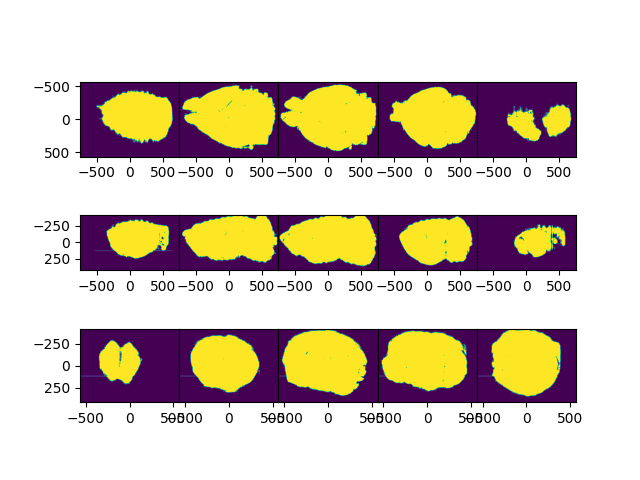

(<Figure size 640x480 with 15 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [12]:
emlddmm.draw(W[None])

<IPython.core.display.Javascript object>


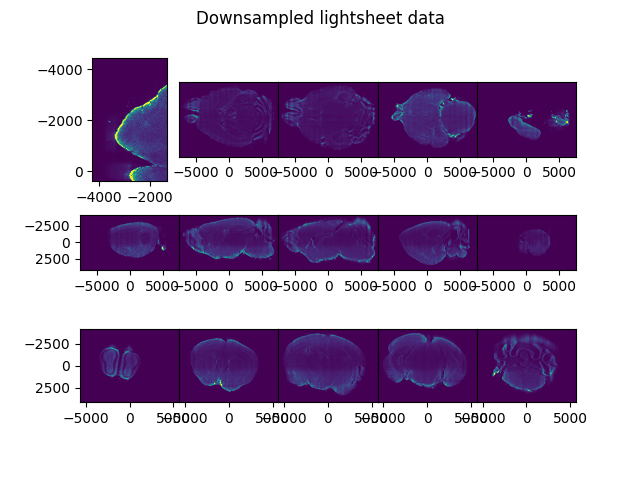

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  after removing the cwd from sys.path.


In [13]:
fig,ax = emlddmm.draw(J,xJ,vmin=np.min(J[W[None]>0.9]))
fig.suptitle('Downsampled lightsheet data')
figopts = {'dpi':300,'quality':90}
fig.savefig(output_prefix + 'downsampled.jpg',**figopts)
fig.canvas.draw()

In [14]:
# with luis, check the origin of this dataset

In [15]:
np.mean(xJ[0]), np.mean(xJ[1]), np.mean(xJ[2])

(2.0, 2.0, -1.0)

In [16]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))
    I.append(I_)
    
I = np.concatenate(I)    
dI = [x[1] - x[0] for x in xI]
XI = np.meshgrid(*xI,indexing='ij')
I,xI = fix_shape(I,xI)

xI0 = [ np.copy(x)for x in xI]
I0 = np.copy(I)

In [17]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [18]:
fig,ax = emlddmm.draw(I[0][None],xI,vmin=0)
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [19]:
# next is to transforom the high resolution data
xS,S,title,names = emlddmm.read_data(seg_name)
# we want to visuze the above with S
labels,inds = np.unique(S,return_inverse=True)

colors = np.random.rand(len(labels),3)
colors[0] = 0.0

RGB = colors[inds].reshape(S.shape[1],S.shape[2],S.shape[3],3).transpose(-1,0,1,2)
#RGB = np.zeros((3,S.shape[1],S.shape[2],S.shape[3]))

#for i,l in enumerate(labels):
#    RGB[:,S[0]==l] = colors[i][...,None]
fig,ax = emlddmm.draw(RGB)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [20]:
# question, do they line up, given that they are different resolutions?
# FIXED
[x[1] - x[0] for x in xS]

[20.0, 20.0, 20.0]

# Initial preprocessing



## Target preprocessing

<IPython.core.display.Javascript object>

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


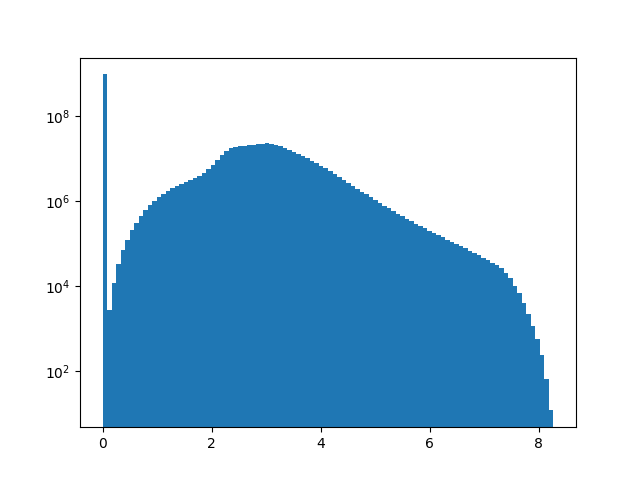

In [21]:
# background
J = J0 - np.quantile(J0[W[None]>0.9],0.1)
J[J<0] = 0
# adjust dynamic range
J = J**0.25

# adjust mean value
J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(J,xJ,vmin=0)
fig.canvas.draw()
fig.suptitle('Preprocessed lightsheet data')
fig.savefig(output_prefix + 'processed.jpg',**figopts)


fig,ax = plt.subplots()
ax.hist(J.ravel(),100,log=True)
fig.canvas.draw()

## Atlas preprocessing


In [22]:
# pad
# since I will downsample by 4, I want to pad with 4x4x4
# here in 10 micron I will need to add more
npad = 8
I = np.pad(I0,  ((0,0),(npad,npad),(npad,npad),(npad,npad)) )
for i in range(npad):
    xI = [ np.concatenate(   (x[0][None]-d,x,x[-1][None]+d)   ) for d,x in zip(dI,xI0)]


In [23]:
# adjust nissl image dynamic range
I[0] = I[0]**0.5
I[0] /= np.mean(np.abs(I[0]))
I[1] /= np.mean(np.abs(I[1]))

<IPython.core.display.Javascript object>


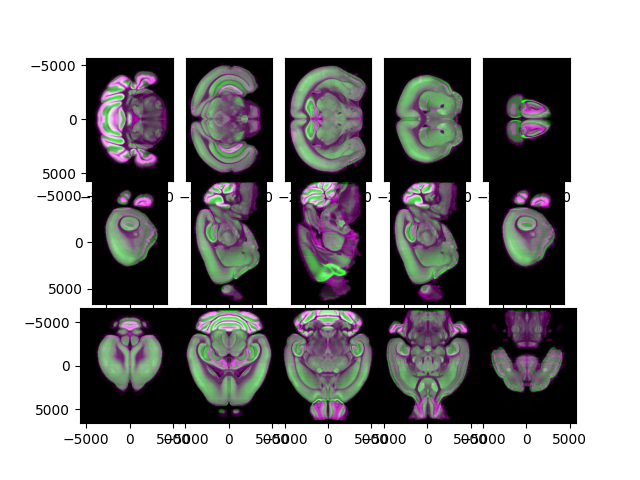

In [24]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

# Registration

In [25]:
L0 = emlddmm.orientation_to_orientation('ARI','IRP')

In [26]:
# initial affine
A0 = np.eye(4)
# make sure to keep sign of Jacobian
#A0 = np.diag((1.3,1.3,1.3,1.0))@A0
# flip x0,x1
A0 = np.array([[0.0,-1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x0,x2
A0 = np.array([[0.0,0.0,-1.0,0.0],[0.0,1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x1,x2
#A0 = np.array([[-1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip 
#A0 = np.diag((1.0,-1.0,-1.0,1.0))@A0
A0[:3,:3] = L0
# shift
#A0[0,-1] = +3500 # left right, positive will cut off the missing hemisphere as appropriate
#A0[1,-1] = -2500 # AP, negative will cut off the nose
#A0[2,-1] = -1000 # SI, negative will move the venttral surface toward the boundary


downcheck = 16

XJ = np.meshgrid(*[x[::downcheck] for x in xJ],indexing='ij')
A0[:3,-1] = np.mean(XJ,axis=(-1,-2,-3))

# check it

tform = emlddmm.Transform(A0,direction='b')
AI = emlddmm.apply_transform_float(xI,I,tform.apply(XJ))
fig,ax = emlddmm.draw(np.concatenate((AI[:2],J[:,::downcheck,::downcheck,::downcheck])),xJ,vmin=0)
fig.canvas.draw()


/home/dtward/data/csh_data/emlddmm/emlddmm.py:3540: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.as_tensor(X,dtype=self.data.dtype,device=self.data.device)


<IPython.core.display.Javascript object>

In [27]:
[x[1] - x[0] for x in xI],[x[1]-x[0] for x in xJ]

([25.0, 25.0, 25.0], [10.0, 10.0, 10.0])

In [28]:
asdf

NameError: name 'asdf' is not defined

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


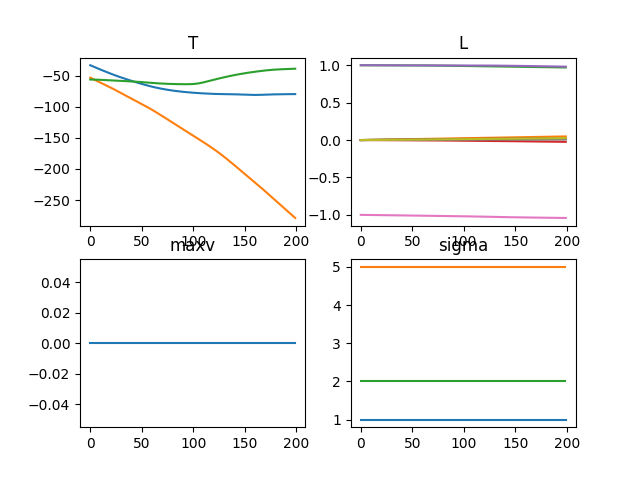

<IPython.core.display.Javascript object>


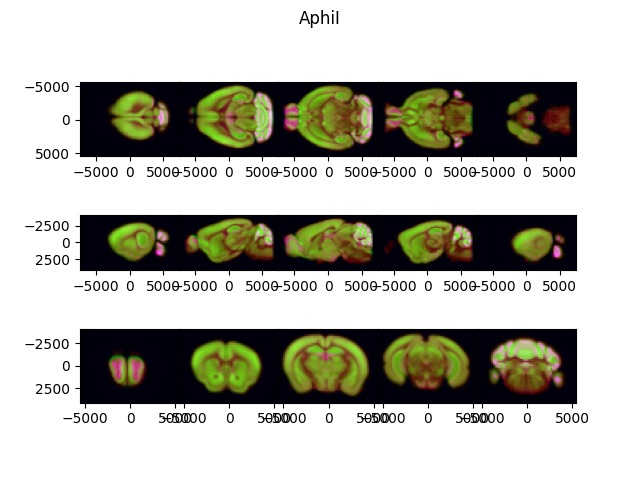

<IPython.core.display.Javascript object>


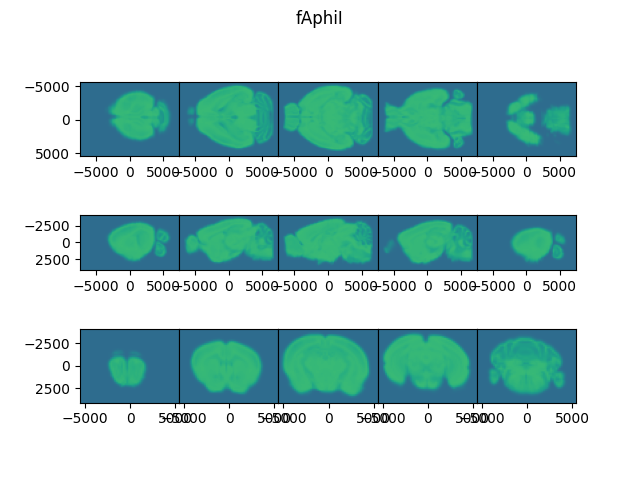

<IPython.core.display.Javascript object>


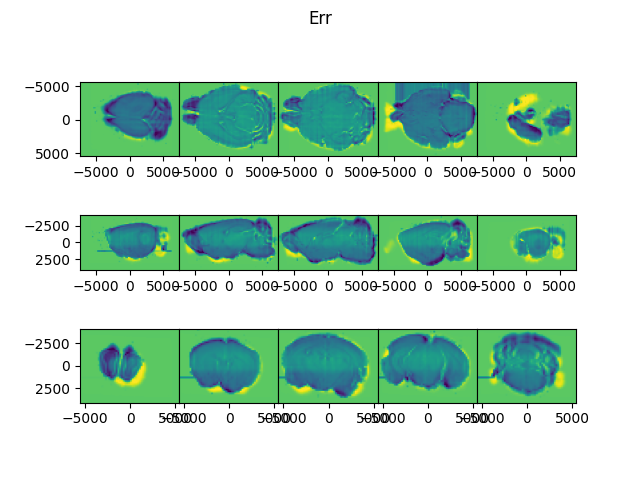

<IPython.core.display.Javascript object>


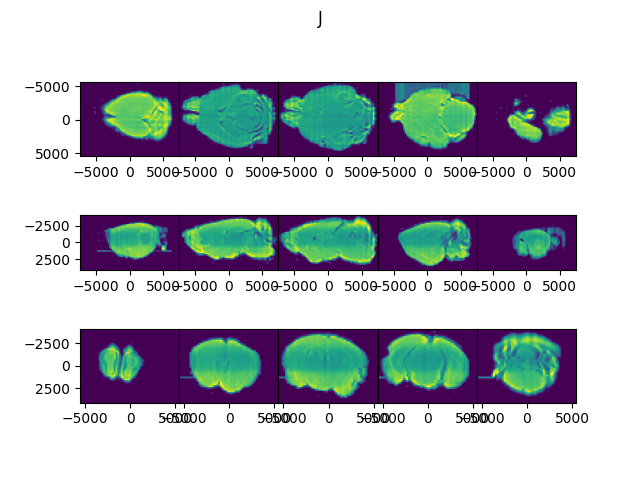

<IPython.core.display.Javascript object>


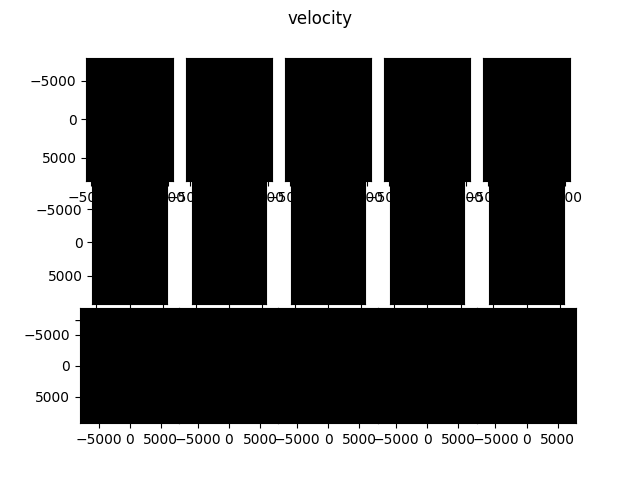

<IPython.core.display.Javascript object>


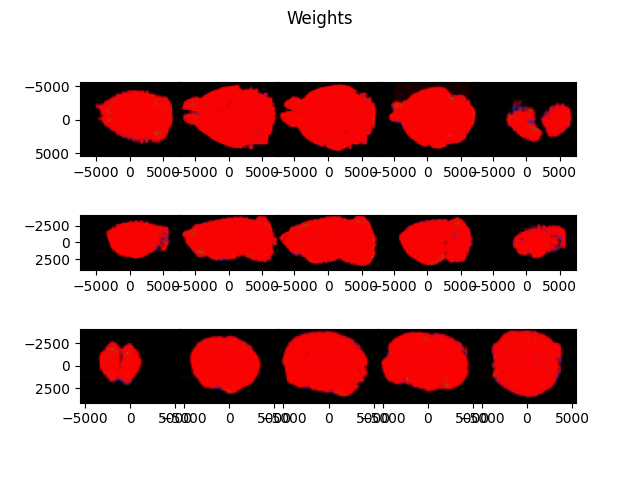

/home/dtward/data/csh_data/emlddmm/emlddmm.py:142: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


In [29]:
# now we want to register
# for 25 micron, we downsample more the first time
config0 = {
    'device':device,
    'dtype':torch.float64, # double
    'n_iter':200, 'downI':[8,8,8], 'downJ':[20,20,20], # start at 200 microns
     'priors':[0.9,0.05,0.05],'update_priors':False,
     'update_muA':0,'muA':[np.quantile(J,0.99)],
     'update_muB':0,'muB':[np.quantile(J,0.01)],
     'update_sigmaM':0,'update_sigmaA':0,'update_sigmaB':0,
     'sigmaM':0.25,'sigmaB':0.5,'sigmaA':1.25,
     'order':1,'n_draw':50,'n_estep':3,'slice_matching':0,'v_start':1000,
     'eA':5e4,'A':A0,'full_outputs':True,
   }

# update my sigmas (august 22)
config0['sigmaM'] = 1.0
config0['sigmaB'] = 2.0
config0['sigmaA'] = 5.0
#W = np.ones_like(J[0])
#W = 1.0 - (J[0]==0)
#I_ = np.stack((I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))
#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2))
#I_ = np.stack((I[0],I[1],I[0]*I[1],I[0]**2,I[1]**2)) # I don't need I[2]
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))

out = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config0)

<IPython.core.display.Javascript object>


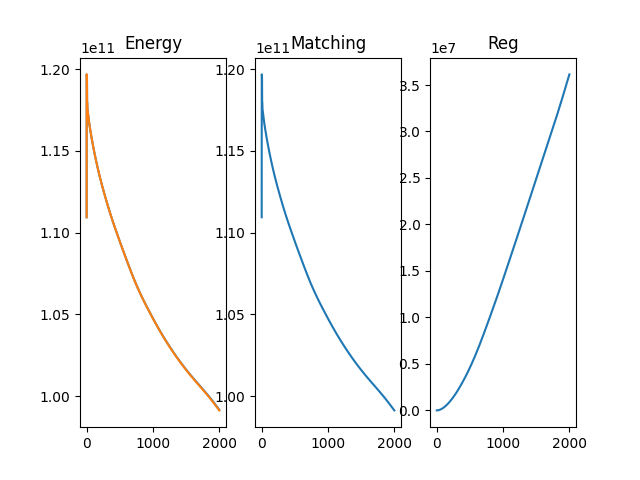

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


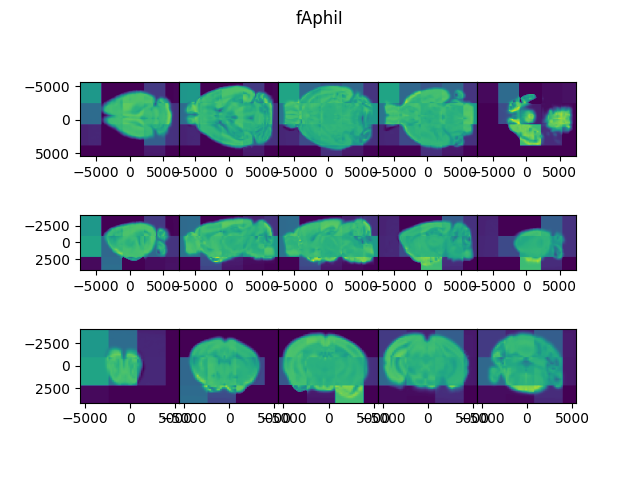

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


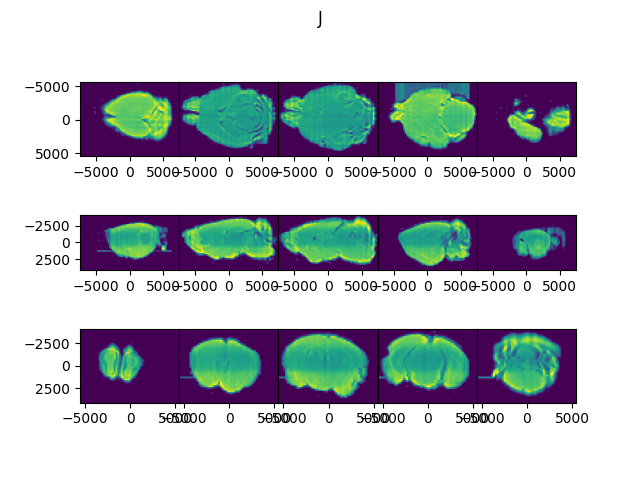

<IPython.core.display.Javascript object>


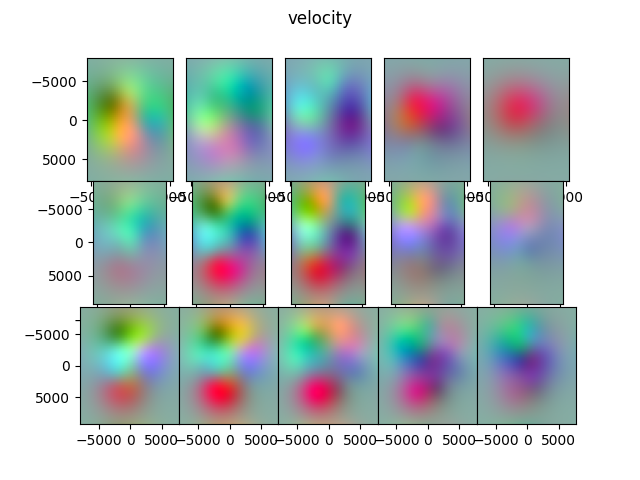

<IPython.core.display.Javascript object>


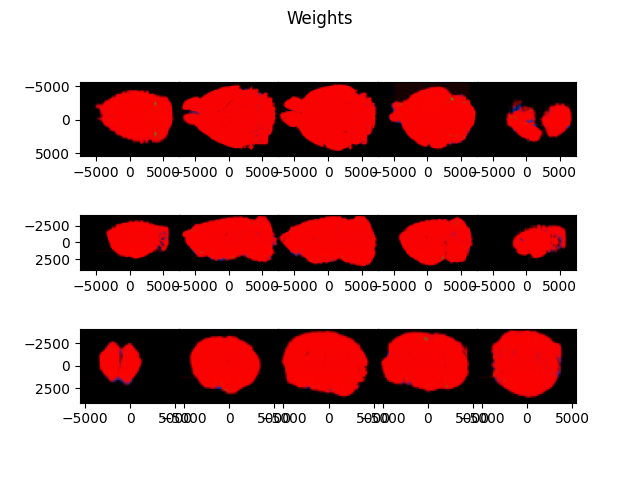

Iteration 1220, translation oscilating, reducing eA to 4500.0
Iteration 1290, linear oscilating, reducing eA to 4050.0
Iteration 1730, translation oscilating, reducing eA to 3645.0
Iteration 1800, translation oscilating, reducing eA to 3280.5


In [32]:
# second run, with deformation
# set the v res factor /4 instead of /2
config1 = dict(config0)
config1['A'] = out['A']
config1['eA'] = config0['eA']*0.1
config1['a'] = 1000.0
config1['sigmaR'] = 5e4 # 1e4 gave really good results, but try 2e4, also good, I showed this in my slides
config1['n_iter']= 2000
config1['v_start'] = 0
config1['ev'] = 1e-2
config1['ev'] = 2e-3 # reduce since I decreased sigma
config1['v_res_factor'] = config1['a']/dI[0]/4 # what is the resolution of v, as a multiple of that in I
config1['local_contrast'] = [32,32,32]
config1['local_contrast'] = [16,16,16]
#config1['device'] = config0['device']

#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))

# note this approach has an issue with background being black
#I_ = np.stack((I[2],I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
#               (I[0]-np.mean(I[0]))**2,
#               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
#               (I[1]-np.mean(I[0]))**2,))
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))


out1 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config1)

In [ ]:
imp.reload(emlddmm)
# on the next run we do les downsampling
config2 = dict(config1)
config2['A'] = out1['A']
config2['n_iter']= 1000
config2['v'] = out1['v']
config2['downI'] = [4,4,4] # change from 2 to 4
config2['downJ'] = [4,4,4]
# there seems to be an issue with the initial velocity
# when I run this twice, I'm reusing it
out2 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config2)
# the matching energy here is way way lower, why would that be?

In [ ]:
# save the outputs
np.save(output_prefix+savename,np.array([out2],dtype=object))

In [ ]:
out2['figI'].savefig(output_prefix + 'transformed.jpg',**figopts)
out2['figfI'].savefig(output_prefix + 'contrast.jpg',**figopts)
out2['figErr'].savefig(output_prefix + 'err.jpg',**figopts)

In [ ]:
fig = out2['figErr']
axs = fig.get_axes()
for ax in axs:
    ims = ax.get_images()
    for im in ims:
        im.set_cmap('twilight')
        clim = im.get_clim()
        lim = np.max(np.abs(clim))
        im.set_clim(np.array((-1,1))*lim)
fig.canvas.draw()
fig.savefig(output_prefix + 'err.jpg',**figopts)

# Prepare some visualizations

In [ ]:
# compute transform for atlas and labels
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='b')
affine = emlddmm.Transform(out2['A'],direction='b')
tform = emlddmm.compose_sequence([affine,deformation],XJ)

In [ ]:
# transform the atlas and labels, notice different domains
It = emlddmm.apply_transform_float(xI,I,tform).cpu().numpy()
RGBt = emlddmm.apply_transform_float(xS,RGB,tform).cpu().numpy()
St = emlddmm.apply_transform_int(xS,S,tform,double=True,padding_mode='zeros').cpu().numpy()

In [ ]:
#fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,Jsave[0]*1.5)),xJ,vmin=0,vmax=4)
#fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,J0[0]*1.5)),xJ,)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'IJsave.jpg')

In [ ]:
fig,ax = emlddmm.draw(It,xJ)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Isave.jpg')

In [ ]:
fig,ax = emlddmm.draw(J,xJ)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Jsave.jpg')

In [ ]:
# transform the target to atlas
# for visualizatoin, we want to sample at xS so we can view it relative to the
XS = np.stack(np.meshgrid(*xS,indexing='ij'))
imp.reload(emlddmm)
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='f')
affine = emlddmm.Transform(out2['A'],direction='f')
tformi = emlddmm.compose_sequence([deformation,affine,],XS)
#J_ = J0**0.25
J_ = np.copy(J)
Jt = emlddmm.apply_transform_float(xJ,J_,tformi,padding_mode='zeros').cpu().numpy()

In [ ]:
# view the transformed target
fig,ax = emlddmm.draw(Jt,xS,vmin=np.quantile(J_,0.02),vmax=np.quantile(J_,0.98))
fig.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
# view the transformed target with labels
minval = 1.5
maxval = 2.9
minval = 0.0
maxval = 5.0
alpha = 0.3
alpha = 0.75
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

In [ ]:
# view the transformed labels with the target
fig = plt.figure(figsize=(8,5))
slices = np.round(np.linspace(0,J.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGBt[:,slices[i]].transpose(1,2,0)
    S_ = St[0,slices[i]]
    Jt_ = np.copy(J[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,J.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGBt[:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,slices[i]]
    Jt_ = np.copy(J[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,J.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGBt[:,:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,:,slices[i]]
    Jt_ = np.copy(J[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Target space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'target_space.jpg',**figopts)

# Get bounding boxes for striatum or another structure

In [ ]:
import requests,csv

In [ ]:
# don't do this because we wlil use Yongsoo ontology
'''
# bounding boxes using St
ontology_name = output_prefix + 'allen_ontology.csv'
r = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,\
rma::criteria,[ontology_id$eq1],\
rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]\
'
if True:# not os.path.exists(ontology_name):
    output = requests.get(r)
    with open(ontology_name,'wt') as f:
        f.write(output.text)
'''        

In [ ]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


In [ ]:
ontology

In [ ]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [ ]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [ ]:
descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

In [ ]:
# or we could just loop through
labels = np.unique(St)
bbox = dict()
for l in labels:
    # skip background
    if l == 0:
        continue
    
    Sl = St == l
    
    # include all the descendents
    for o in descendents_and_self[l]:
        Sl = np.logical_or(Sl,St==o)
    
    
    bbox2 = xJ[2][np.nonzero(np.sum(Sl,(0,1,2))>0)[0][[0,-1]]]
    bbox1 = xJ[1][np.nonzero(np.sum(Sl,(0,1,3))>0)[0][[0,-1]]]
    bbox0 = xJ[0][np.nonzero(np.sum(Sl,(0,2,3))>0)[0][[0,-1]]]
    bbox[l] = (bbox2[0],bbox2[1],bbox1[0],bbox1[1],bbox0[0],bbox0[1],ontology[l][0],ontology[l][1])
    


In [ ]:
import pandas as pd
df = pd.DataFrame(bbox).T
bbox_headings = ('x0','x1','y0','y1','z0','z1','short name','long name')
df.columns=bbox_headings
df.index.name = 'id'

In [ ]:
df

In [ ]:
df.to_csv(output_prefix + 'bboxes.csv')

In [ ]:
# TODO, separate left from right in bounding box

In [ ]:
# TODO, use a surface instead of bounding box. use marching cubes. figure out file format.

In [ ]:
# see link on slack vrml (wireframe objects9-)

In [ ]:
def compute_face_normals(verts,faces,normalize=False):
    e1 = verts[faces[:,1]] - verts[faces[:,0]]
    e2 = verts[faces[:,2]] - verts[faces[:,1]]
    n = np.cross(e1,e2)/2.0
    if normalize:
        n /= np.sqrt(np.sum(n**2,1,keepdims=True))
        pass
    return n

In [ ]:
# TODO for daniel, write out surfaces that are parent and all the descendents (february 15)

In [ ]:
from skimage.measure import marching_cubes
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
oJ = [x[0] for x in xJ]
labels = np.unique(St)
bbox = dict()

In [ ]:
1

In [ ]:
for l in ontology:
    print(f'starting {l}')
    # skip background
    if l == 0:
        print('skipping 0')
        continue
    
    Sl = St == l
    count0 = np.sum(Sl)
    # do marching cubes
    print('adding ',end='')
    for o in descendents_and_self[l]:
        print(f'{o},',end='')
        Sl = np.logical_or(Sl,St==o)
    count1 = np.sum(Sl)
    if count0 != count1:
        print(f'Structure {l} shows differences')
    if count1 == 0:
        print(f'no voxels for structure {l}')
        continue
    
    verts,faces,normals,values = marching_cubes(Sl[0]*1.0,level=0.5,spacing=dJ)
    # deal with the offsets
    verts += oJ
    
    # let's save this
    readme = 'Data are saved in ZYX order'
    np.savez(output_prefix + f'structure_AND_DESCENDENTS_{l:012d}_surface.npz',verts=verts,faces=faces,normals=normals,values=values,readme=readme)
    
    surf = Poly3DCollection(verts[faces])
    n = compute_face_normals(verts,faces,normalize=True)
    surf.set_color(n*0.5+0.5)
    fig.clf()
    ax = fig.add_subplot(projection='3d')
    ax.add_collection3d(surf)
    xlim = (np.min(verts[:,0]),np.max(verts[:,0]))
    ylim = (np.min(verts[:,1]),np.max(verts[:,1]))
    zlim = (np.min(verts[:,2]),np.max(verts[:,2]))
    # fix aspect ratio
    r = [np.diff(x) for x in (xlim,ylim,zlim)]
    rmax = np.max(r)
    c = [np.mean(x) for x in (xlim,ylim,zlim)]
    xlim = (c[0]-rmax/2,c[0]+rmax/2)
    ylim = (c[1]-rmax/2,c[1]+rmax/2)
    zlim = (c[2]-rmax/2,c[2]+rmax/2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    ax.set_title(f'structure {l}, {ontology[l][1]} ({ontology[l][0]})')    
    fig.canvas.draw()
    fig.savefig(output_prefix + f'structure_AND_DESCENDENTS_{l:012d}_surface.jpg')

In [ ]:
for l in ontology:print(l)

# Map atlas surface points

Unfortunately the topology of our surfaces is not working out well.  We will want to map surface vertices directly.

In [ ]:
asdf

In [ ]:
oS = np.array([x[0] for x in xS])
dS = [x[1] - x[0] for x in xS]

In [ ]:
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='f')
affine = emlddmm.Transform(out2['A'],direction='f')
tform = emlddmm.compose_sequence([deformation,affine],XS)

In [ ]:
for l in ontology:
    print(f'starting {l}')
    # skip background
    if l == 0:
        print('skipping 0')
        continue
    
    #
    #Sl = St == l
    Sl = S == l # use the original segmentations
    count0 = np.sum(Sl)
    # do marching cubes
    print('adding ',end='')
    for o in descendents_and_self[l]:
        print(f'{o},',end='')
        #Sl = np.logical_or(Sl,St==o)
        Sl = np.logical_or(Sl,S==o)
    count1 = np.sum(Sl)
    if count0 != count1:
        print(f'Structure {l} shows differences')
    if count1 == 0:
        print(f'no voxels for structure {l}')
        continue
    #
    
    
    #verts,faces,normals,values = marching_cubes(Sl[0]*1.0,level=0.5,spacing=dJ)
    verts,faces,normals,values = marching_cubes(Sl[0]*1.0,level=0.5,spacing=dS)
    # deal with the offsets
    #verts += oJ
    verts += oS
    
    
    # now we need to transform these points
    vertsout = emlddmm.interp(xS,tform,torch.tensor(verts.T[...,None,None],dtype=tform.dtype))[:,:,0,0].T
    # for some reason, it seems like these are transposed relative to the previous version
    # okay because I forgot to change the name below, verts -> vertsout
    verts = vertsout.cpu().numpy()
    
    # let's save this
    readme = 'Data are saved in ZYX order'
    np.savez(output_prefix + f'structure_AND_DESCENDENTS_{l:012d}_v02_surface.npz',verts=verts,faces=faces,normals=normals,values=values,readme=readme)
    
    surf = Poly3DCollection(verts[faces])
    n = compute_face_normals(verts,faces,normalize=True)
    surf.set_color(n*0.5+0.5)
    fig.clf()
    ax = fig.add_subplot(projection='3d')
    ax.add_collection3d(surf)
    xlim = (np.min(verts[:,0]),np.max(verts[:,0]))
    ylim = (np.min(verts[:,1]),np.max(verts[:,1]))
    zlim = (np.min(verts[:,2]),np.max(verts[:,2]))
    # fix aspect ratio
    r = [np.diff(x) for x in (xlim,ylim,zlim)]
    rmax = np.max(r)
    c = [np.mean(x) for x in (xlim,ylim,zlim)]
    xlim = (c[0]-rmax/2,c[0]+rmax/2)
    ylim = (c[1]-rmax/2,c[1]+rmax/2)
    zlim = (c[2]-rmax/2,c[2]+rmax/2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    ax.set_title(f'structure {l}, {ontology[l][1]} ({ontology[l][0]})')    
    fig.canvas.draw()
    fig.savefig(output_prefix + f'structure_AND_DESCENDENTS_{l:012d}_v02_surface.jpg')

In [ ]:
verts

In [ ]:
out2['xv'],tform.shape

In [ ]:
vertsout.shape,verts.shape

In [ ]:
verts.T.shape,tform.shape

# Map neurons
We will want to use these maps to apply to swc files

/qnap/3D_stitched_LS/20220725_SW220510_02_LS_6x_1000z/Ex_488_Em_525_Terafly_Ano/recut/run-13_model_base_rf_17_55_57_19_23_19/sort/Maybe_structures/structure_000000000981_surface

note that this probably should be done AFTER registration, not during, since the swc files may not be ready yet.

Let's use good structures instead of maybe structures.

In [ ]:
1